In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Read in data and remove unneeded index column
df=pd.read_csv('../../data/TimeSeries/checkoutstimeseries.csv',parse_dates=['Year-Month'])
df = df.drop('Unnamed: 0', axis=1)
df.head()


,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
0,2005-04-01,143053,0,37432,32157,0,40021
1,2005-05-01,227864,0,58138,53305,0,62088
2,2005-06-01,287908,0,70580,67821,0,76130
3,2005-07-01,195018,0,49752,48457,0,50441
4,2005-08-01,210033,0,55664,53192,0,54818


In [4]:
#Our data is unreliable after April of 2024, so we drop the rows after this.
df = df.drop(df[df['Year-Month'] > pd.to_datetime('2024-04-01') ].index)
df.tail()

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008
227,2024-03-01,240492,269650,14148,47753,232102,9279
228,2024-04-01,232015,258261,13424,44527,221409,9053


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
#Make our test-train-split
df_train=df[df['Year-Month']< pd.to_datetime('2023-05-01')]
df_test=df[df['Year-Month']>= pd.to_datetime('2023-05-01')]

In [7]:
df_test.head(13)

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
217,2023-05-01,234008,245842,13735,42223,199974,7133
218,2023-06-01,243120,244555,13883,42370,201215,7520
219,2023-07-01,254000,264058,13274,42414,212350,7989
220,2023-08-01,259623,262905,14209,44633,217048,8623
221,2023-09-01,239205,252549,12838,42896,208961,8168
222,2023-10-01,242487,260825,12756,44176,216269,8671
223,2023-11-01,229088,255659,12904,42698,211135,8650
224,2023-12-01,218063,271133,14063,46244,220101,8465
225,2024-01-01,249991,286052,14163,48465,241287,9470
226,2024-02-01,227572,257818,14385,45266,218335,9008


## Visualizations and Data Exploration: 

We plot our time series to see their overall form: 

In [8]:
# Material types we have a time series for
materials = ['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other' ]

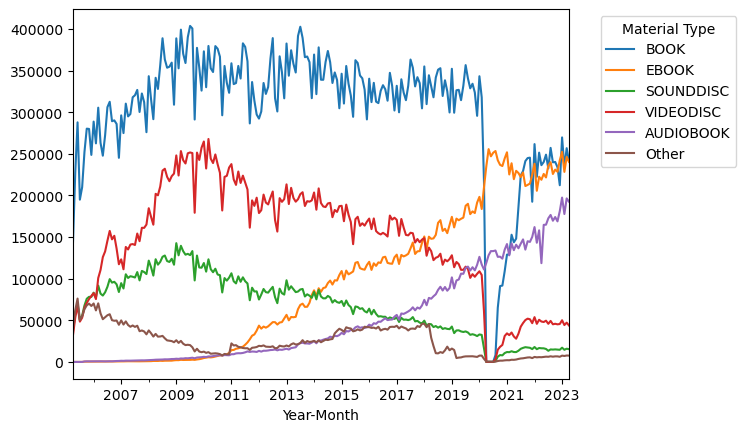

In [9]:
df_train.plot(x='Year-Month', y=materials)
plt.legend(title='Material Type',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It looks like there is a linear trend in books, videodiscs, sound discs, and ebooks, and an exponential/higher order polynomial trend in audiobooks. It is unclear if there is seasonality in these plots. We also note the clear drop in books , sound discs, and videodiscs during COVID and well as the rise in ebooks at this time. 

We plot the autocorrelation of each time series to understand the stationarity and seasonality of each series.

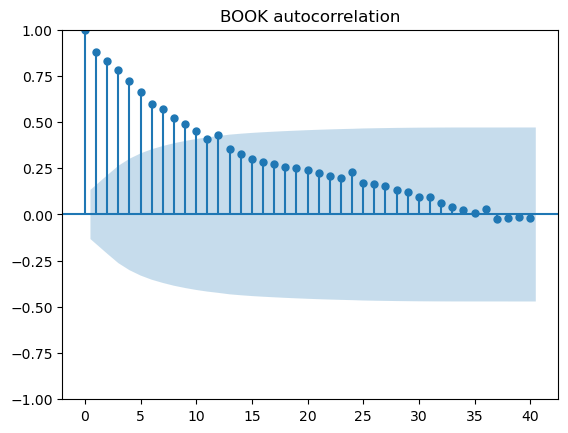

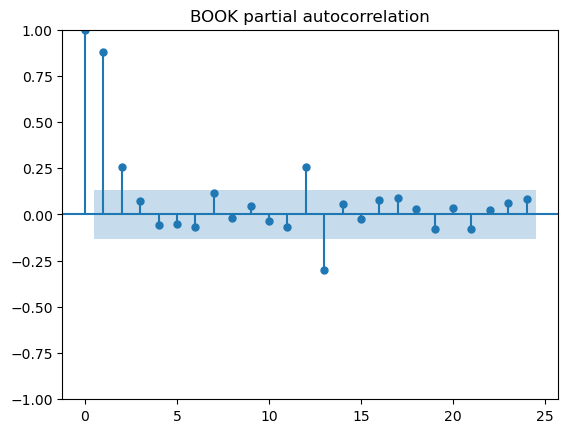

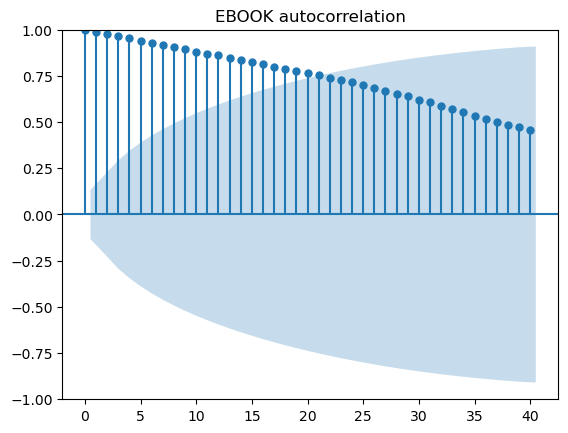

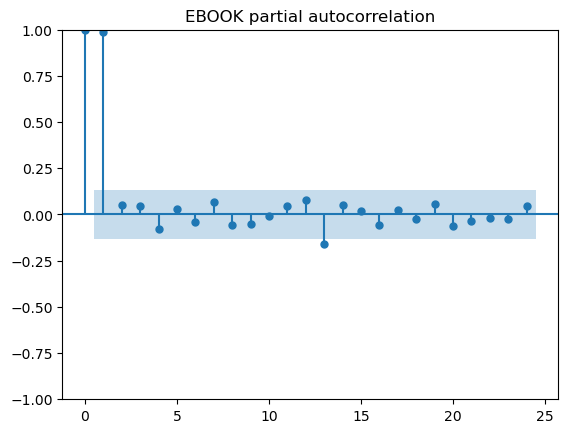

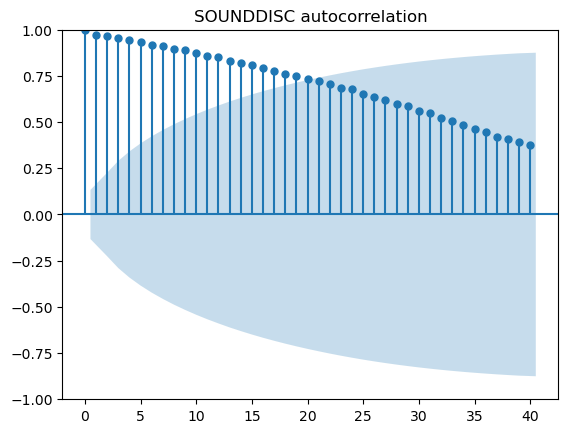

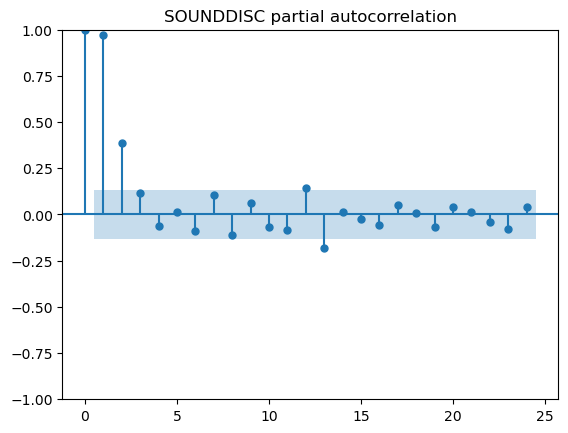

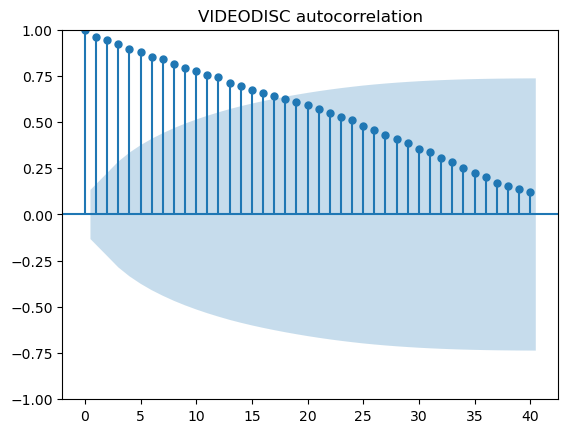

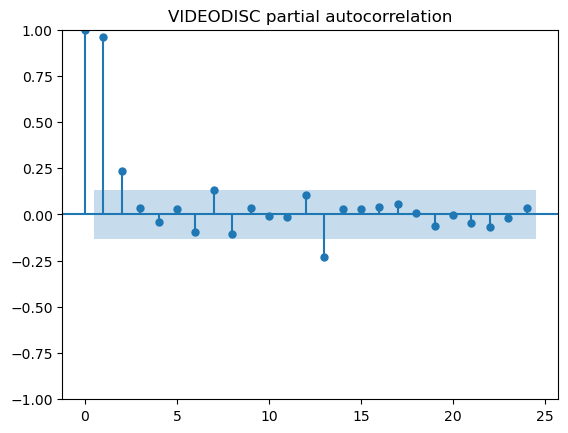

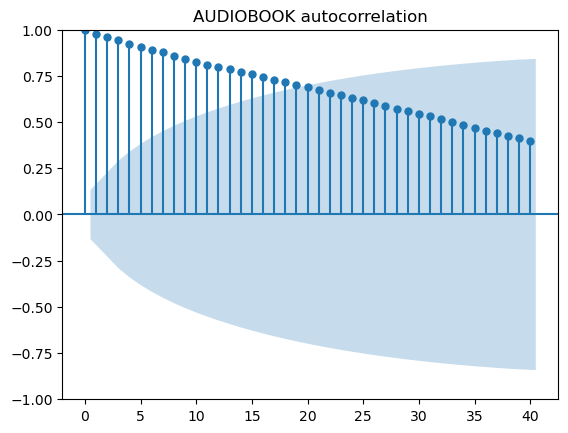

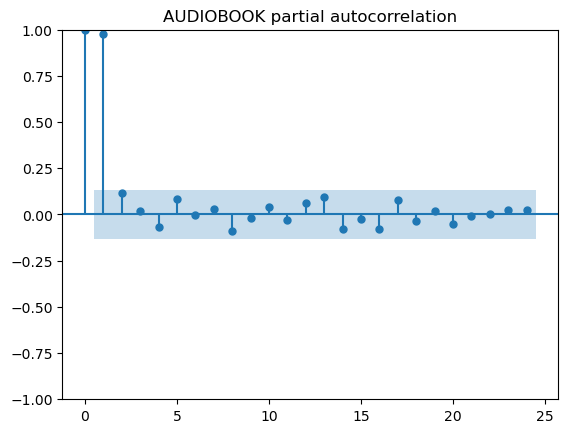

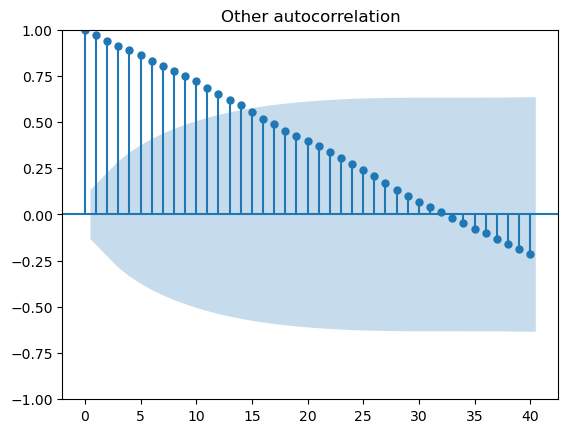

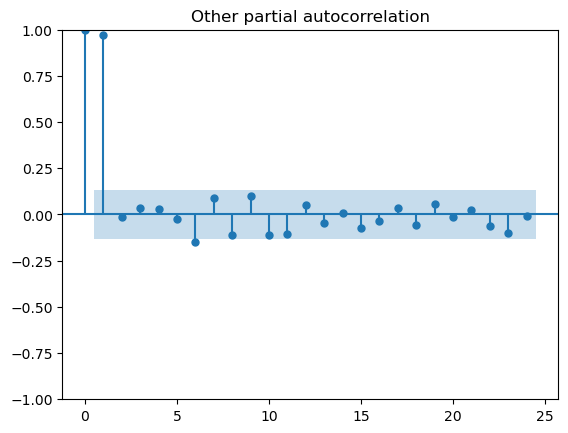

In [10]:
#Let's see how much autocorrelation there is
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for x in materials:
    plot_acf(df_train[x], lags=40)
    plt.title(x + ' autocorrelation')
    plot_pacf(df_train[x])
    plt.title(x + ' partial autocorrelation')
    plt.show()


From the slow decay of the autocorrelation for each series, we see that the series are not stationary. The bump at lags 12 and 24 in the BOOK time series seems to indicate some form of yearly seasonality; however, it is unclear if the other time series have such seasonality. In the partial autocorrelation graphs, the smaller lag numbers seem more important, though multiple series have jumps at lag 12/13.

Another way to consider the trend and seasonality of the time series is with Seasonal-Trend decomposition using LOESS (STL). STL using LOESS (locally estimated scatterplot smoothing) to decompose the time series into trend, season, and residual, allowing from nonlinear trends and changing seasonality. 

BOOK


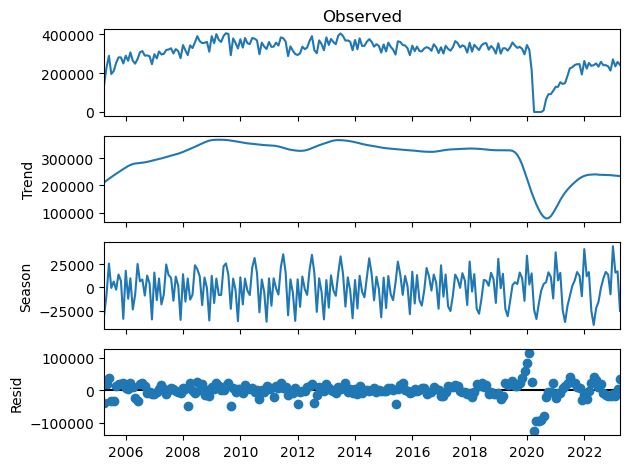


EBOOK


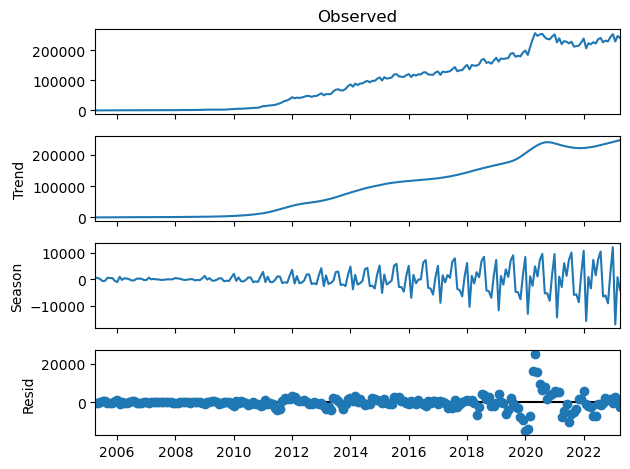


SOUNDDISC


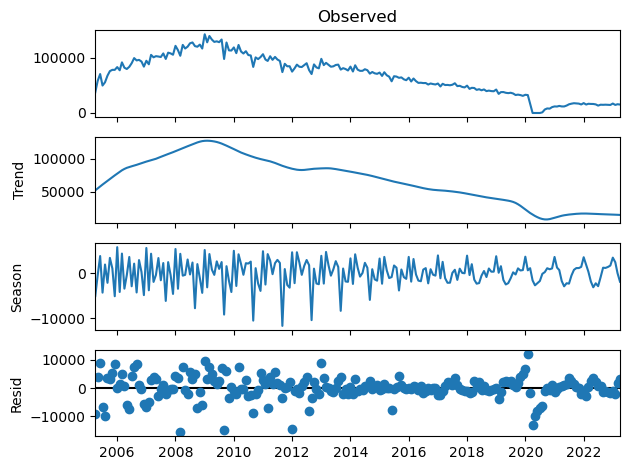


VIDEODISC


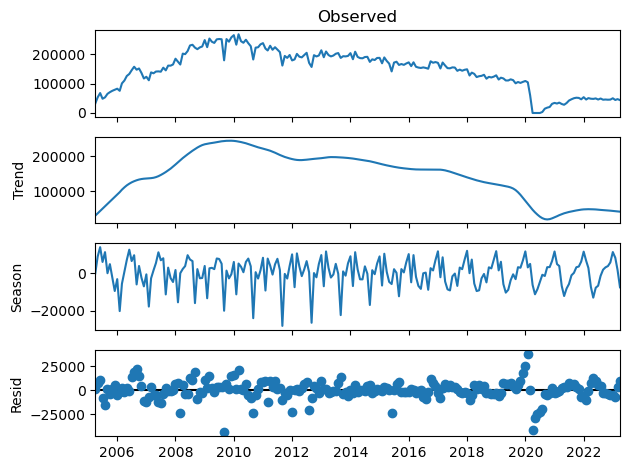


AUDIOBOOK


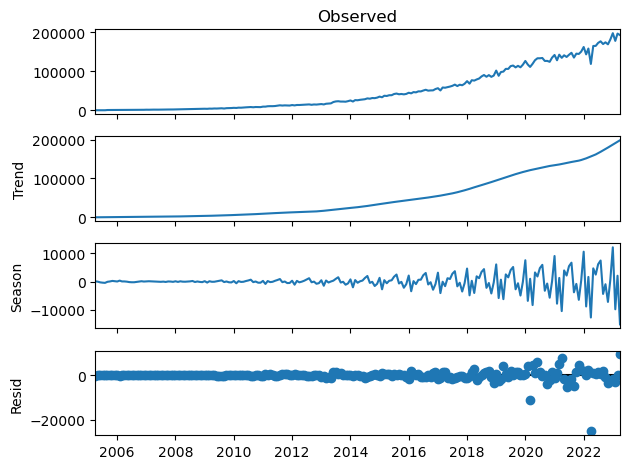


Other


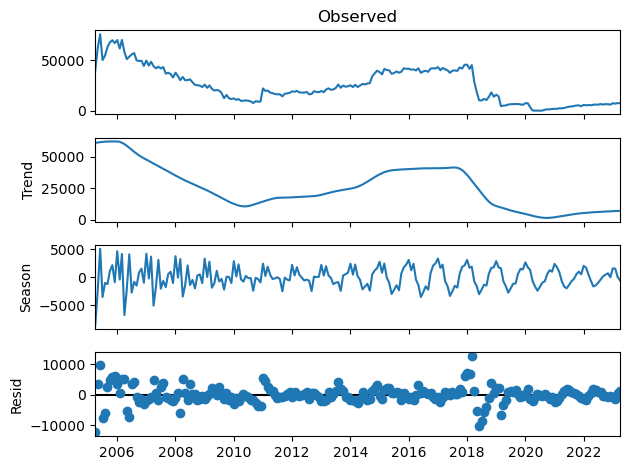

In [11]:
from statsmodels.tsa.seasonal import STL

# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train[material].values, index=df_train['Year-Month'], columns=[material])
    print(material)
    stl= STL(df_seasonal, seasonal=13)
    res = stl.fit()
    fig = res.plot()
    plt.show()
    print()

We see that BOOK has fairly even seasonality throughout its history, whereas EBOOK and AUDIOBOOK develop more seasonality with time which makes sense given the increase in popularity of these materials with time. The seasonality in VIDEODISC, SOUNDDISC, and OTHER seems to decrease in frequency in the later years. 

There are different ways we can handle the trend element of our model including using the STL decomposition above, using differencing in an ARIMA model to obtain a stationary series, or removing the trend beforehand and predicting on that and the remainder of the series separately before combining.

To remove the trend beforehand, we will fit a spline model to account for the trend; the spline model should better fit the trend, compared to for example a linear regresison model, especially with the large shock in some of the time series near COVID.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

We will set equally spaced knots with some additional knots around the pandemic to better model the shock. To do so, we consider the times series near the pandemic:

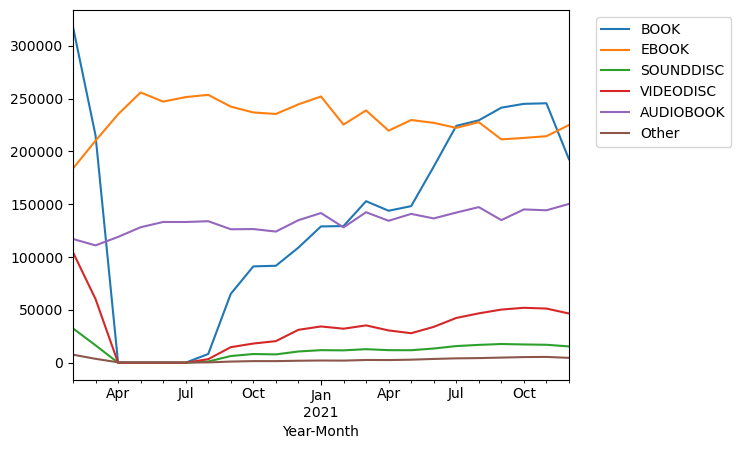

In [13]:
df_pandemicera=df_train[(df_train['Year-Month']<pd.to_datetime('2022-01-01')) & (df_train['Year-Month']>pd.to_datetime('2020-01-01'))]

df_pandemicera.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

In [14]:
#get the indices of April, July and October 2020
df_pandemicera.head(10)

,Year-Month,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
178,2020-02-01,317946,183789,32491,104503,117082,7620
179,2020-03-01,215128,210061,16494,60309,111031,3692
180,2020-04-01,70,235051,5,5,119039,402
181,2020-05-01,87,255745,1,3,128189,268
182,2020-06-01,43,247083,0,4,133186,246
183,2020-07-01,52,251359,2,12,133161,213
184,2020-08-01,8276,253472,1155,3374,133910,316
185,2020-09-01,65204,242337,6332,14705,126290,1093
186,2020-10-01,91168,236818,8236,18152,126477,1522
187,2020-11-01,91740,235396,7876,20432,124111,1516


In [15]:
trendpipeline=Pipeline([('spline',SplineTransformer(knots=np.array([0,30, 60, 90, 120, 150,180,183,186,216]).reshape(-1,1), degree=3, extrapolation='linear')),
                        ('regression',LinearRegression())])

In [16]:
#make a pandas dataframe  to store the trend 
df_train_trend=df_train.__deepcopy__()

for feature in materials:
    trendpipeline.fit(X=np.array(df_train.index).reshape(-1,1),y=df_train[feature])
    prediction=trendpipeline.predict(X=np.array(df_train.index).reshape(-1,1))
    df_train_trend[feature]=prediction


We plot the fitted trends below:

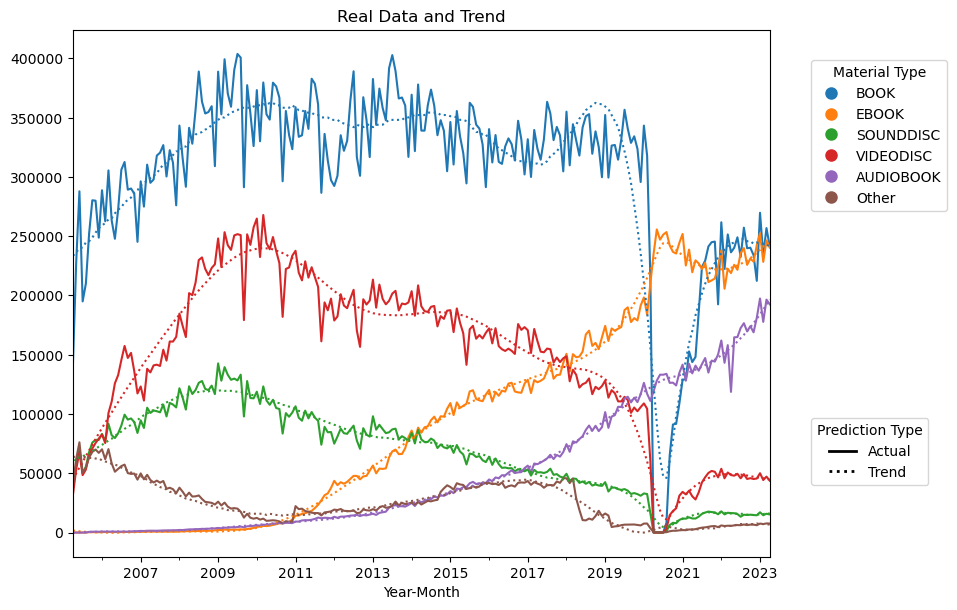

In [17]:
from matplotlib.lines import Line2D

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Trend': ':'}

fig, ax = plt.subplots(figsize=(12, 6))
df_train.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], color=colors, ls=linestyles['Actual'], ax=ax)
df_train_trend.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], color=colors, ls=linestyles['Trend'], ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Real Data and Trend')
plt.show()

We can now remove the trends and plot the resulting time series:

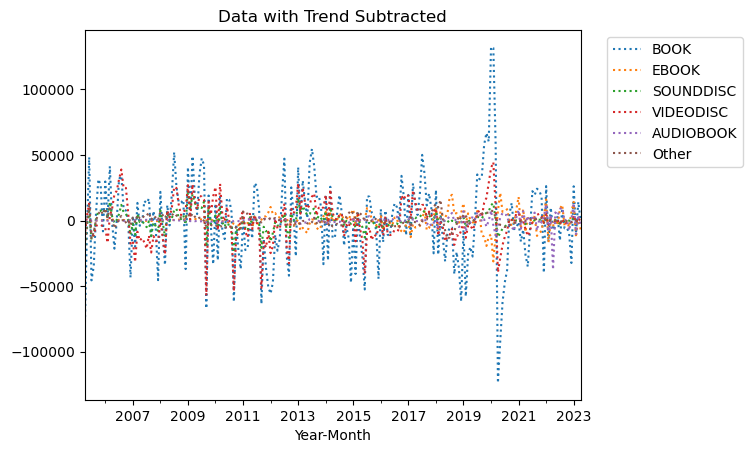

In [18]:
#subtract the trend.
df_train_no_trend=df_train.__deepcopy__()

for feature in materials:
    df_train_no_trend[feature]=df_train[feature]-df_train_trend[feature]

#plt.figure(figsize=(10,5))

df_train_no_trend.plot(x='Year-Month', y=['BOOK', 'EBOOK','SOUNDDISC',  'VIDEODISC' ,'AUDIOBOOK', 'Other'], ls=":")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Data with Trend Subtracted')
plt.show()


This data looks more stationary with possibly some seasonality, particuarly in books. 

## Forecasting Models: 

There are a few modeling techniques we explore for our time series which are described below:


- #### Linear Regression (Baseline Model):

    Assume that the time series is a linear function of time plus some random noise, i.e.:

    $$
    f(t) = \beta_0 + \beta_1 t + \epsilon_t
    $$

    where $\beta_0, \beta_1 \in \mathbb{R}$ and $\epsilon_t \sim \operatorname{NID}(0,\sigma^2)$ is guassian white noise error term.



- #### Seasonal Naive with Trend: 
    Add a trend component to the seasonal naive forecast:

    $$
    f(t) = \left\lbrace \begin{array}{l c c}y_\tau + \beta(t-n) + \epsilon, & \text{for} & t > n  \\
                                            y_t & \text{for} & t\leq n
                                            \end{array}\right.,
    $$

    where 

    $$
    \tau = t - \left(\left\lfloor \frac{t - n}{m} \right\rfloor + 1\right) m, \text{ with } \lfloor \bullet \rfloor \text{ denoting the floor function.} 
    $$
    Here a season lasts $m$ timesteps and $\beta$ can be estimated with the average value of the first seasonal differences $\nabla y_t = y_t - y_{t-m}$

- #### STLForecast: 
    Subtract the seasonal component from the time series, forecast on the deseasonalized time series via ARIMA to get the forecast of the trend and residual components, forecast the seasonality under the assumption that future seaonal components will repeat the last observed seasonal cycle, and add the deseasonalized and seasonal components together to get the final forecast. 

- #### Autoarima: 
    Without removing any seasonality or trend, we run an autoarima function to find the best order (p, d, q) for an ARIMA model for each material type and use this to forecast the time series. 

- #### Autoarima with trend removed and seasonality: 
    Identify the trend using the trendpipeline above, remove the trend and run autoarima on the remainder accounting for seasonality, forecast on the trend and remainder separately, and add the results to get the final forecast. 

We now consider the autocorrelation and partial autocorrelation functions for the time series with trend removed to gain some intuition the ARIMA orders:

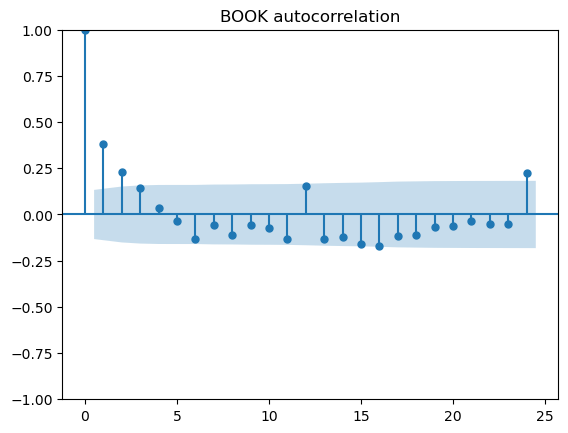

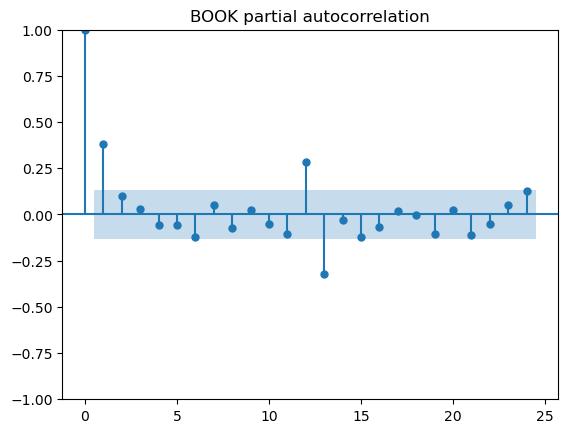

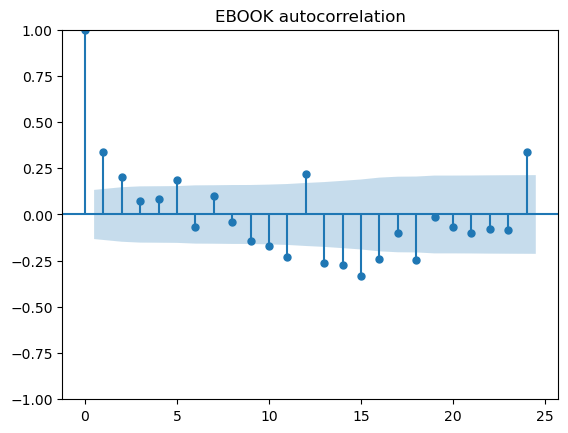

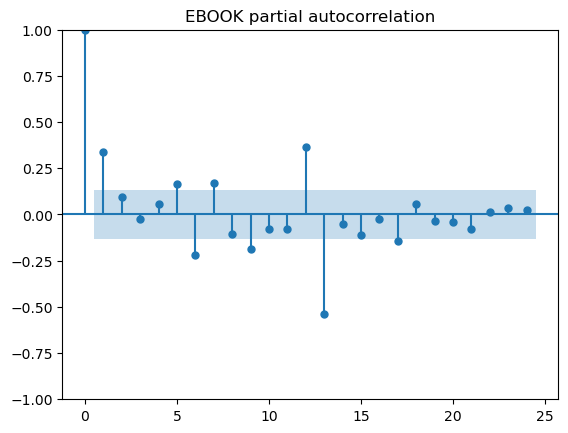

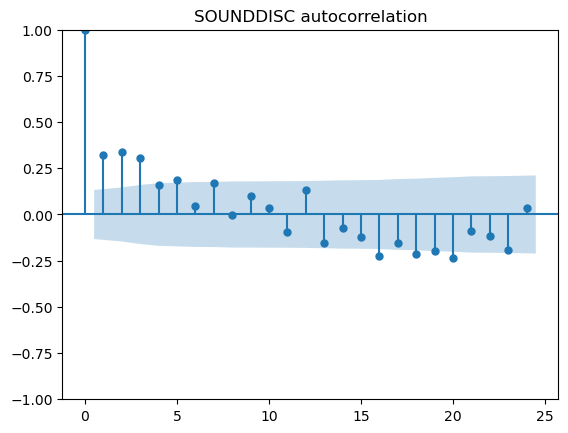

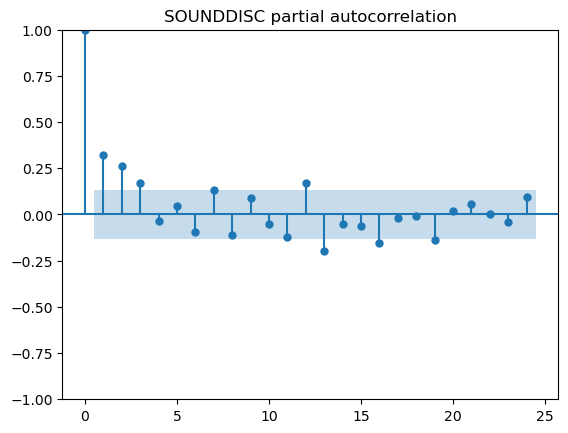

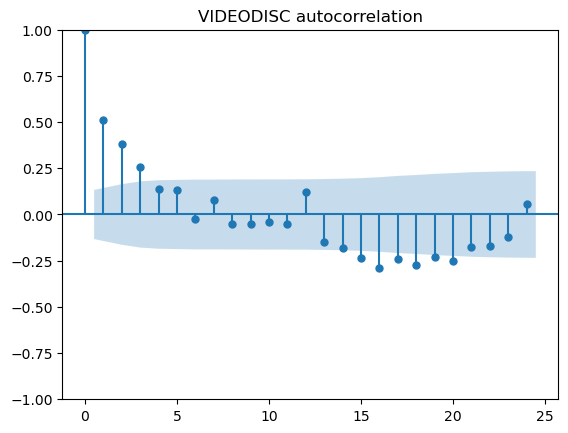

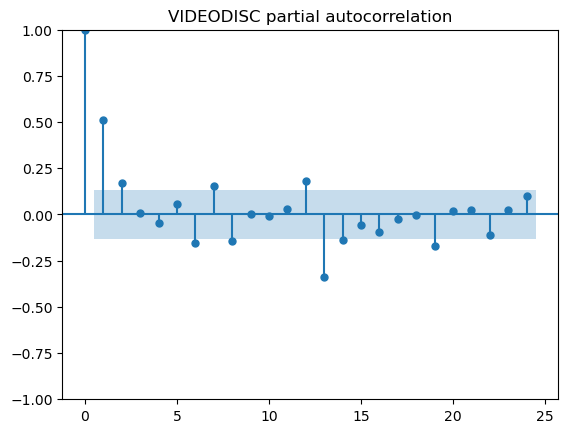

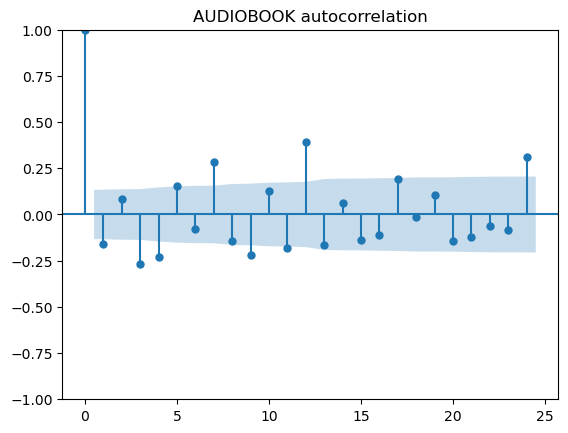

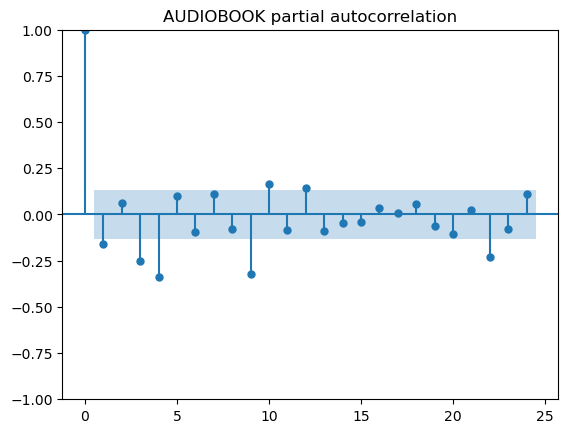

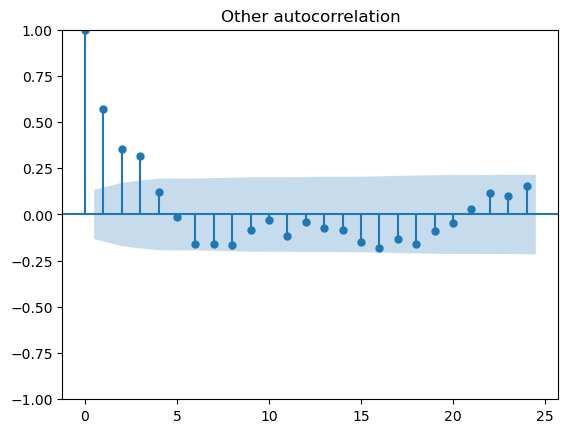

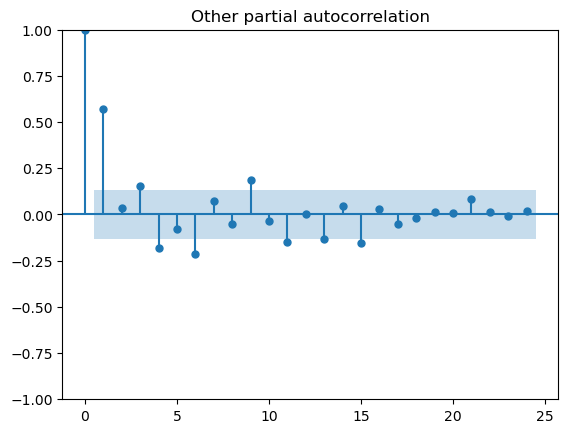

In [19]:
# Plot ACF and PACF for detrended data
for x in materials:
    plot_acf(df_train_no_trend[x])
    plt.title(x + ' autocorrelation')
    plot_pacf(df_train_no_trend[x])
    plt.title(x + ' partial autocorrelation')
    plt.show

From the autocorrelation plots, we see that the detrended data is much more stationary, though we may still want to difference to gain more stationarity. We see that in most categories the PACF have bigger spikes at 12 and 13 months, which might be dealt with when accouting for seasonality or the lingering nonstationarity. 

We also consider the partial autocorrelation functions of the deseasonalized data from STL to gain intuition on what would be the best model order: 

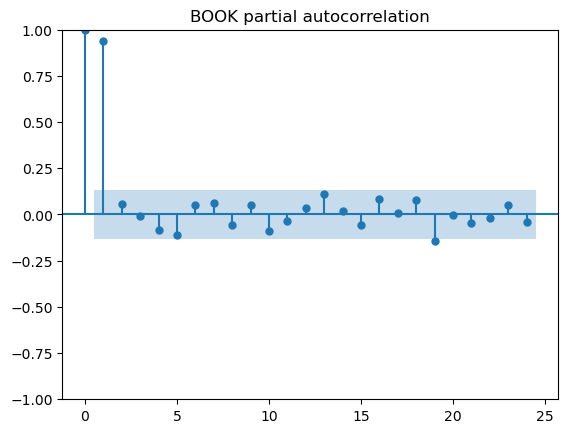

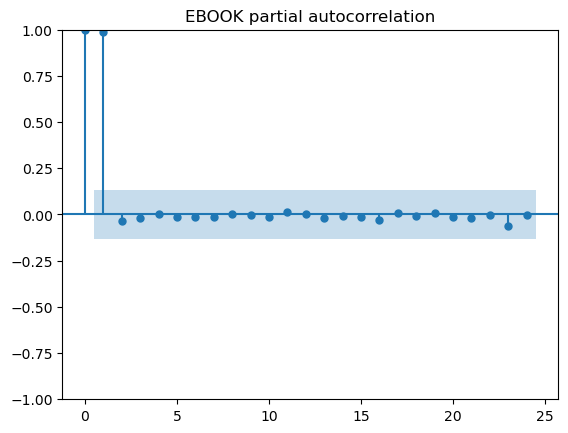

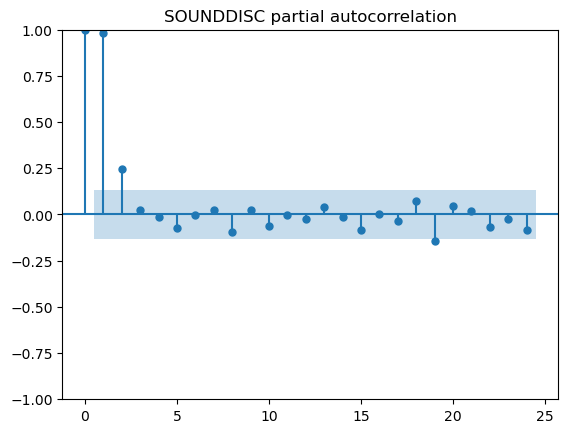

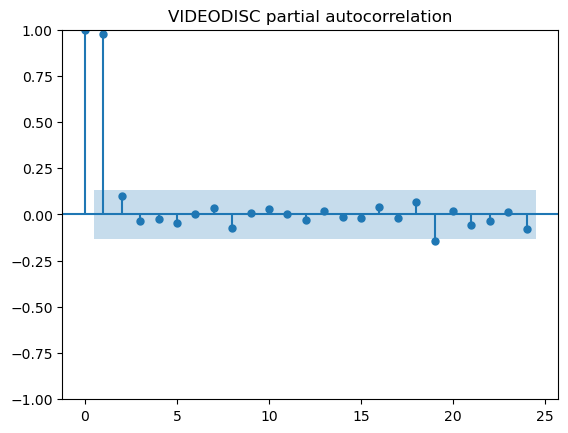

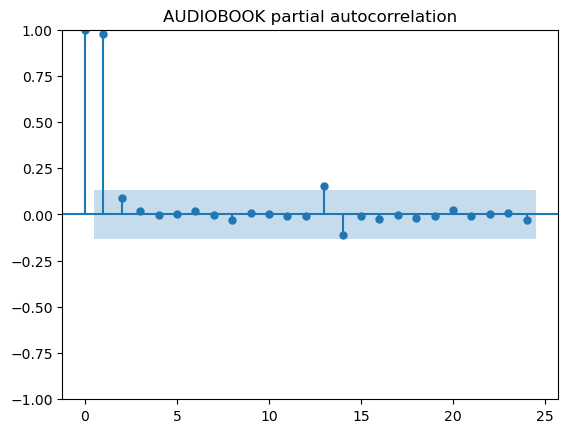

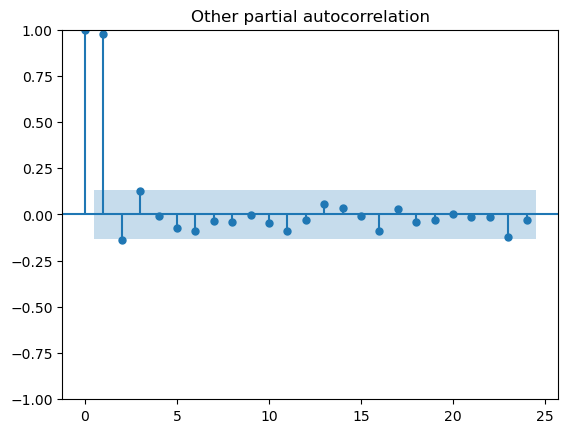

In [20]:
from statsmodels.tsa.seasonal import STL


# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train[material].values, index=df_train['Year-Month'], columns=[material])
    stl= STL(df_seasonal, seasonal=13)
    res = stl.fit()
    # Get series without seasonality
    deseasonalized = df_seasonal[material].values- res.seasonal
    plot_pacf(deseasonalized)
    plt.title(material + ' partial autocorrelation')
    plt.show()
    

From these graphs, we would expect the most the time series to have an AR(1) model, with SOUNDDISC possibly having an AR(2) model.

For the STL forecasting, we will use autoarima to find the appropriate ARIMA order. We do this for the whole train time series as well as the time series pre-2020 as COVID yields a significant shock in our data that should be anamolous. 

In [21]:
import pmdarima as pm

orders = []

# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train[material].values, index=df_train['Year-Month'], columns=[material])
    stl= STL(df_seasonal, seasonal=7)
    res = stl.fit()
    # Get series without seasonality
    deseasonalized = df_seasonal[material].values- res.seasonal
    # Run autoarima on this data
    autoarima=pm.auto_arima(deseasonalized)
    orders.append(autoarima.order)
    print(material, ': ', autoarima.order)

orders_dict = dict(zip(materials, orders))

BOOK :  (0, 1, 0)
EBOOK :  (1, 1, 0)
SOUNDDISC :  (1, 2, 1)
VIDEODISC :  (1, 2, 1)
AUDIOBOOK :  (1, 2, 2)
Other :  (3, 1, 2)


In [22]:
df_train_preCOVID = df_train[df_train['Year-Month'] < pd.to_datetime('2020-01-01') ]

orders_preCOVID = []

# Decompose the time series
for material in materials:
    df_seasonal = pd.DataFrame(df_train_preCOVID[material].values, index=df_train_preCOVID['Year-Month'], columns=[material])
    stl= STL(df_seasonal, seasonal=13)
    res = stl.fit()
    # Get series without seasonality
    deseasonalized = df_seasonal[material].values- res.seasonal
    # Run autoarima on this data
    autoarima=pm.auto_arima(deseasonalized)
    #pm.auto_arima(df_train['BOOK'].diff()[1:], seasonal=True, m=12)
    orders_preCOVID.append(autoarima.order)
    print(material, ': ', autoarima.order)


orders_preCOVID_dict = dict(zip(materials, orders_preCOVID))


BOOK :  (0, 1, 0)
EBOOK :  (1, 2, 1)
SOUNDDISC :  (1, 2, 2)
VIDEODISC :  (0, 2, 2)
AUDIOBOOK :  (0, 2, 2)
Other :  (1, 1, 0)


The orders of ARIMA are similar for pre-COVID data and the whole training data, but we will use the pre-COVID values as we expect that the behavior of these time series should be more reflective of pre-COVID behavior the further from the pandemic we get. 

## Forecasting:

We are now ready to forecast on our training data: 

In [23]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape

In [24]:
# Initialize baseline model
baseline_linear=LinearRegression()

# Initialize dataframes to store predictions
baseline_preds=pd.DataFrame(index=df_train.index, columns=materials)
seasonal_naive_preds = pd.DataFrame(index=df_train.index, columns=materials)
STL_preds = pd.DataFrame(index=df_train['Year-Month'], columns=materials)
autoarima_preds=pd.DataFrame(index=df_train.index, columns=materials)
autoarima_no_trend_withseasonality_preds=pd.DataFrame(index=df_train.index, columns=materials)

In [25]:
# Time Series Cross Valididation object
tscv=TimeSeriesSplit(n_splits=12, test_size=1)

for train_index, test_index in tscv.split(df_train):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    print(test_index)
    for material in materials: 
        #Baseline Predictions
        baseline_linear.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[material])
        baseline_preds.loc[test_index,material]=baseline_linear.predict(X=np.array(test_index).reshape(-1,1))

        #Seasonal Naive with Trend Predictions
        beta_hat = df_tt[material].diff(12).mean()/12.0
        data= df_tt[material].values
        seasonal_naive_preds.loc[test_index,material] = data[test_index-12] + beta_hat*(test_index-len(df_tt))

        #STL Predictions
        df_seasonal = pd.DataFrame(df_tt[material].values, index=df_tt['Year-Month'], columns=[material])
        df_seasonal = df_seasonal.asfreq('MS')
        stlf = STLForecast(df_seasonal, ARIMA, model_kwargs=dict(order=orders_preCOVID_dict[material], freq=df_seasonal.index.inferred_freq))
        stlf_res = stlf.fit()
        forecast = stlf_res.forecast(1)
        date = forecast.index.to_pydatetime()[0]
        STL_preds.loc[date,material]= forecast.values[0]

        #Autoarima Predictions
        autoarima=pm.auto_arima(df_tt[material],error_action='ignore')
        print("Auto arima order for", material, autoarima.order )
        autoarima_preds.loc[test_index,material]=autoarima.predict(n_periods=1)

        #Autoarima No Trend with Seasonality Predictions
        trendpipeline.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[material])
        prediction_of_trend=trendpipeline.predict(X=np.array(train_index).reshape(-1,1))
        data_without_trend=df_tt[material]-prediction_of_trend
        autoarima_no_trend_with_seasonality=pm.auto_arima(data_without_trend,seasonal=True, m=12, error_action='ignore', stationary=True)
        print("Auto arima with seasonality order and seasonal order for", material,  autoarima_no_trend_with_seasonality.order, autoarima_no_trend_with_seasonality.seasonal_order )
        autoarima_no_trend_withseasonality_preds.loc[test_index,material]=autoarima_no_trend_with_seasonality.predict(n_periods=1)+trendpipeline.predict(X=np.array(test_index).reshape(-1,1))

# Add Year-Month columns and drop NA rows
STL_preds = STL_preds.reset_index().dropna()
baseline_preds.insert(0,'Year-Month', df_train['Year-Month'])
seasonal_naive_preds.insert(0,'Year-Month', df_train['Year-Month'])
autoarima_preds.insert(0,'Year-Month', df_train['Year-Month'])
autoarima_no_trend_withseasonality_preds.insert(0,'Year-Month', df_train['Year-Month'])
baseline_preds = baseline_preds.dropna()
seasonal_naive_preds = seasonal_naive_preds.dropna()
autoarima_preds = autoarima_preds.dropna()
autoarima_no_trend_withseasonality_preds = autoarima_no_trend_withseasonality_preds.dropna()


[205]
Auto arima order for BOOK (1, 1, 0)
Auto arima with seasonality order and seasonal order for BOOK (2, 0, 2) (1, 0, 1, 12)
Auto arima order for EBOOK (1, 1, 0)
Auto arima with seasonality order and seasonal order for EBOOK (1, 0, 0) (1, 0, 2, 12)
Auto arima order for SOUNDDISC (1, 2, 2)
Auto arima with seasonality order and seasonal order for SOUNDDISC (1, 0, 1) (1, 0, 1, 12)
Auto arima order for VIDEODISC (2, 2, 5)
Auto arima with seasonality order and seasonal order for VIDEODISC (2, 0, 0) (1, 0, 1, 12)
Auto arima order for AUDIOBOOK (1, 1, 0)
Auto arima with seasonality order and seasonal order for AUDIOBOOK (2, 0, 2) (1, 0, 0, 12)
Auto arima order for Other (2, 1, 2)
Auto arima with seasonality order and seasonal order for Other (3, 0, 1) (2, 0, 1, 12)
[206]
Auto arima order for BOOK (1, 1, 0)
Auto arima with seasonality order and seasonal order for BOOK (1, 0, 1) (1, 0, 1, 12)
Auto arima order for EBOOK (1, 1, 0)
Auto arima with seasonality order and seasonal order for EBOOK 

We can plot our predictions for the various models: 

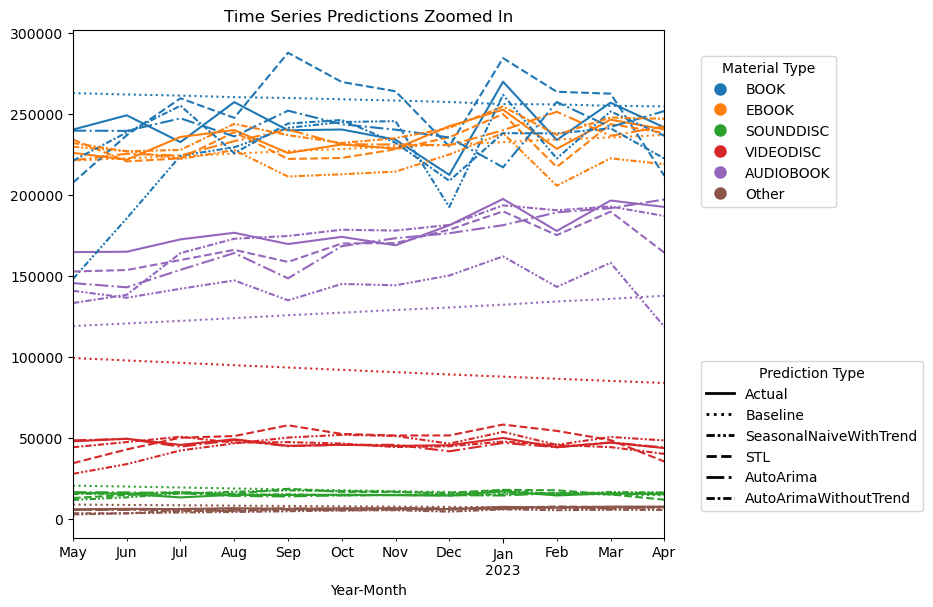

In [26]:
#Get true values of df_train at predicted indices
df_train_end = df_train[df_train.index >= baseline_preds.index[0]]

# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))


# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Baseline': ':','SeasonalNaiveWithTrend':(0, (3, 1, 1, 1, 1, 1)), 'STL': '--', 'AutoArima': '-.', 'AutoArimaWithoutTrend': (0, (3, 1, 1, 1))}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_train_end.plot(x='Year-Month', y=materials, color=colors, ax=ax)
baseline_preds.plot(x='Year-Month', y=materials, ls=linestyles['Baseline'], color=colors, ax=ax)
seasonal_naive_preds.plot(x='Year-Month', y=materials, ls=linestyles['SeasonalNaiveWithTrend'], color=colors, ax=ax)
STL_preds.plot(x='Year-Month', y=materials, ls=linestyles['STL'], color=colors, ax=ax)
autoarima_preds.plot(x='Year-Month', y=materials, ls=linestyles['AutoArima'], color=colors, ax=ax)
autoarima_no_trend_withseasonality_preds.plot(x='Year-Month', y=materials, ls=linestyles['AutoArimaWithoutTrend'], color=colors, ax=ax)

# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions Zoomed In')
plt.show()

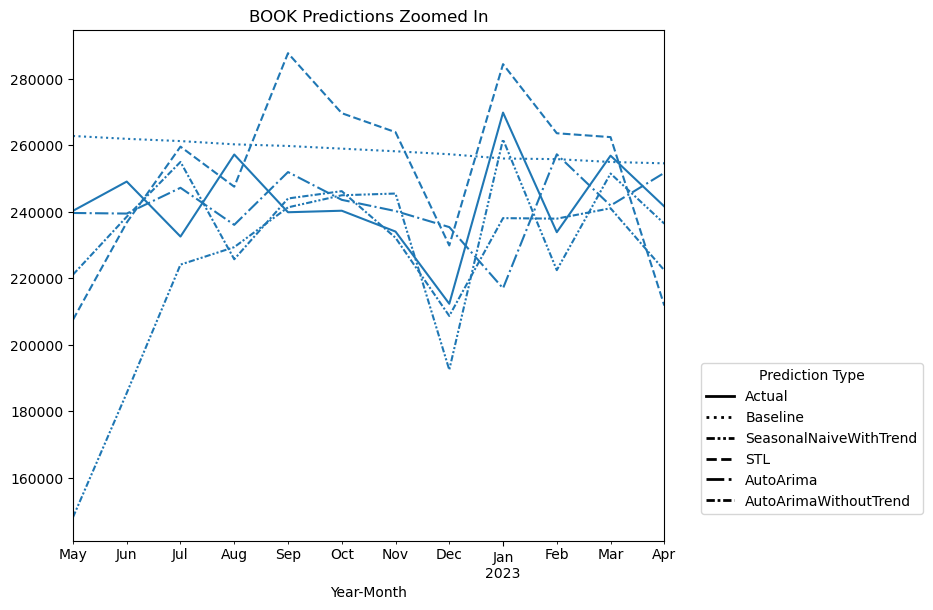

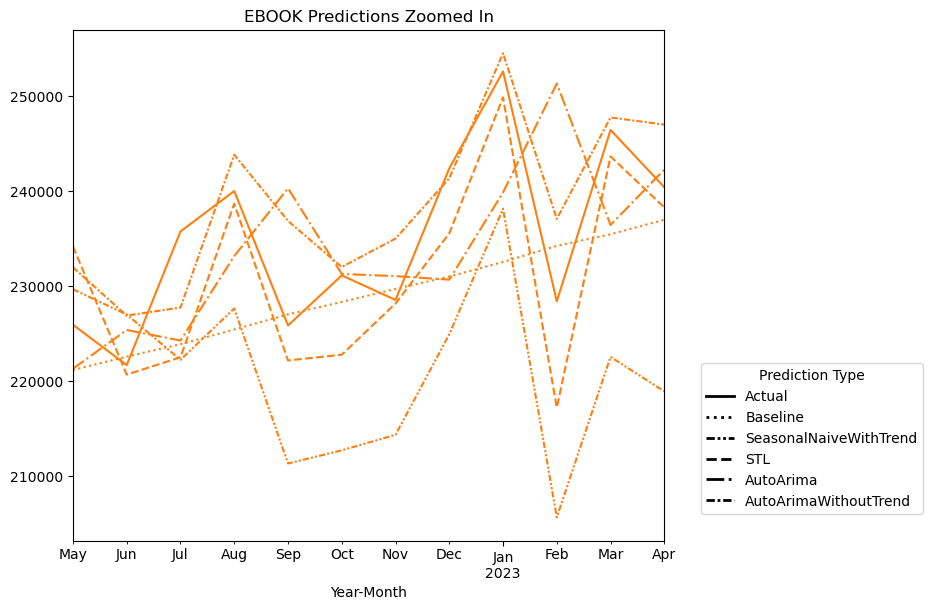

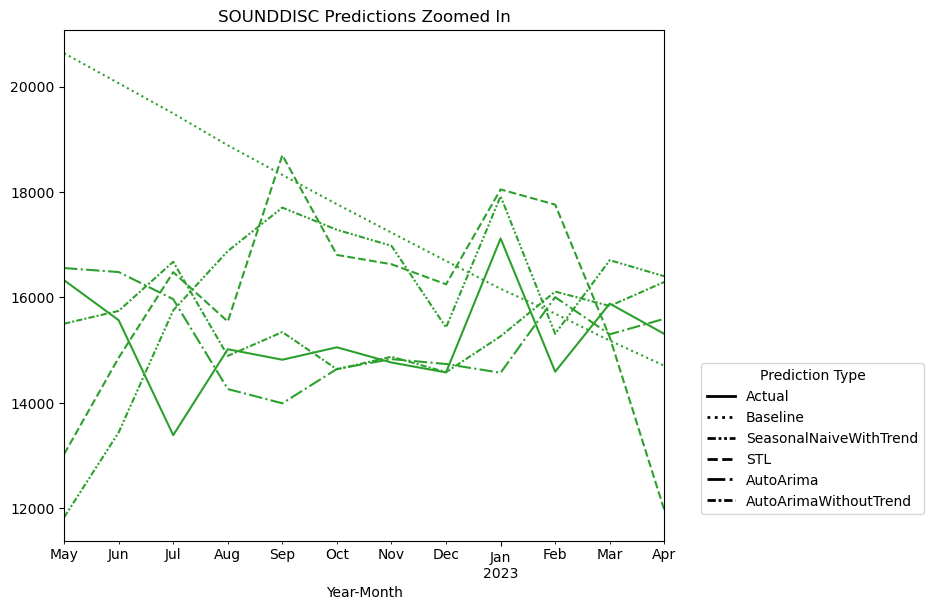

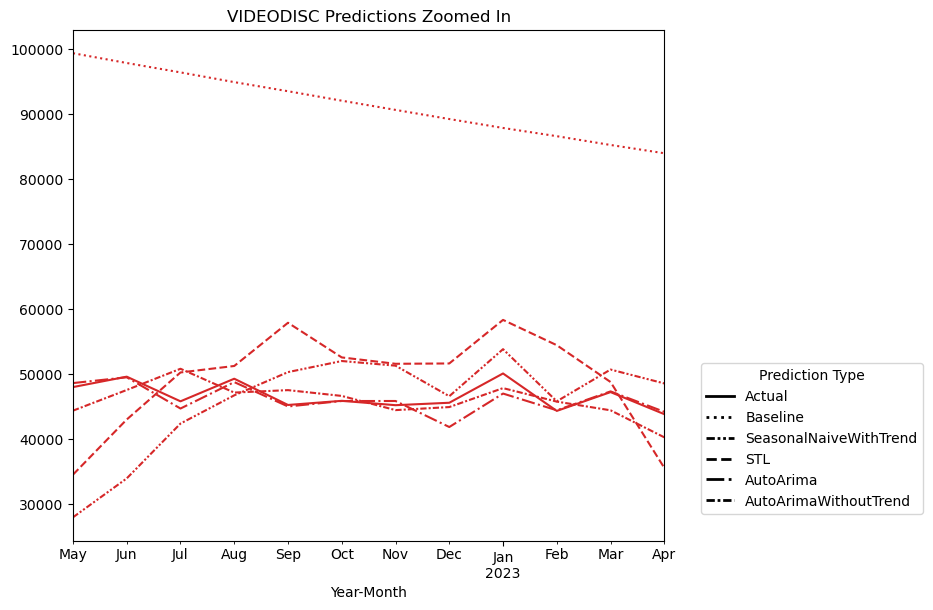

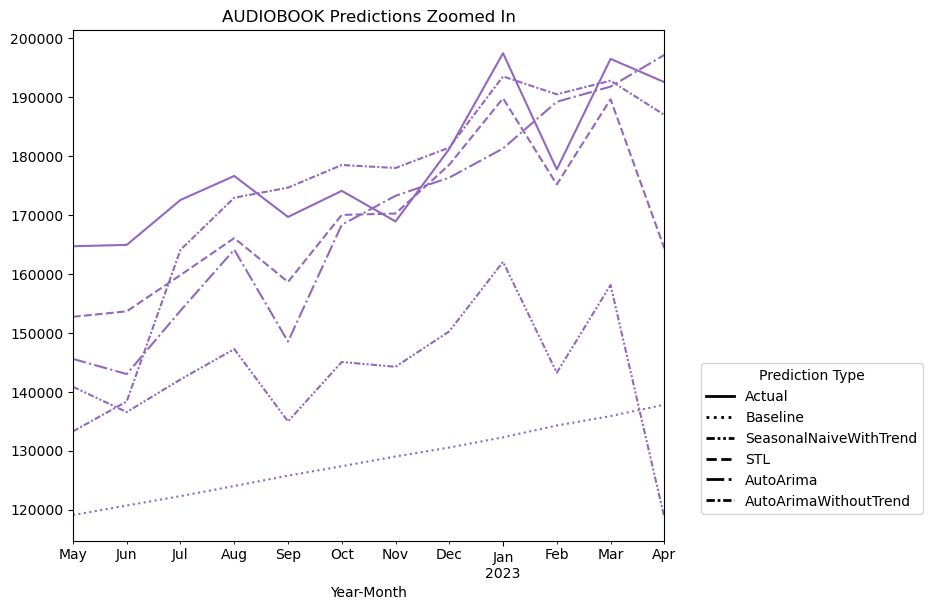

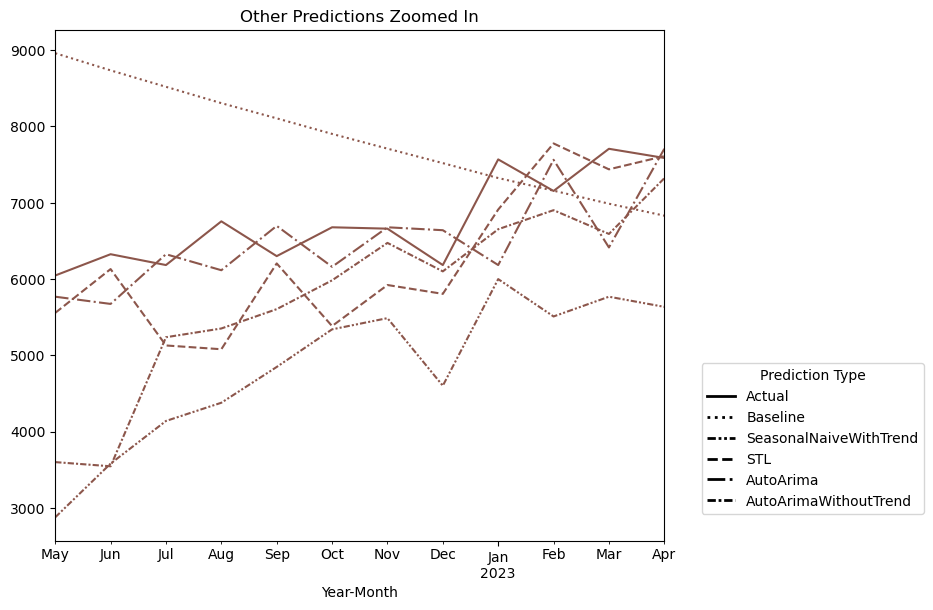

In [27]:
for material in materials:
# Plot predictions with whole time series
    fig, ax = plt.subplots(figsize=(12, 6))
    df_train_end.plot(x='Year-Month', y=material, color=colors, ax=ax)
    baseline_preds.plot(x='Year-Month', y=material, ls=linestyles['Baseline'], color=colors, ax=ax)
    seasonal_naive_preds.plot(x='Year-Month', y=material, ls=linestyles['SeasonalNaiveWithTrend'], color=colors, ax=ax)
    STL_preds.plot(x='Year-Month', y=material, ls=linestyles['STL'], color=colors, ax=ax)
    autoarima_preds.plot(x='Year-Month', y=material, ls=linestyles['AutoArima'], color=colors, ax=ax)
    autoarima_no_trend_withseasonality_preds.plot(x='Year-Month', y=material, ls=linestyles['AutoArimaWithoutTrend'], color=colors, ax=ax)

    # Create custom legends
    color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
    linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

    # Add legends outside the plot
    #color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.05, 0.8))
    #ax.add_artist(color_legend)  # Add material type legend first
    linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.05, 0.2))

    # Adjust layout to make room for legends
    plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
    plt.title(material+' Predictions Zoomed In')
    plt.show()

We now want to compute the root mean square errors (RMSEs) and mean absolute percentage errors (MAPEs): 

In [28]:
# Get indicies of start and end of testing data
first_idx = baseline_preds.index.values[0]
last_idx = baseline_preds.index.values[-1]

error_indices = ['Baseline RMSE', 'SeasonalNaiveWithTrend RMSE', 'STL RMSE', 'AutoArima RMSE', 'AutoArimawithoutTrend RMSE', 
                 'Baseline MAPE', 'SeasonalNaiveWithTrend MAPE', 'STL MAPE', 'AutoArima MAPE', 'AutoArimawithoutTrend MAPE']

# Create dataframe to hold the errors
df_train_errors=pd.DataFrame(index=error_indices, columns=materials)

# Calculate errors for each model
for feature in materials:
    df_train_errors.loc['Baseline RMSE',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=baseline_preds[feature].values)
    df_train_errors.loc['SeasonalNaiveWithTrend RMSE',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=seasonal_naive_preds[feature].values)
    df_train_errors.loc['STL RMSE',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=STL_preds[feature].values)
    df_train_errors.loc['AutoArima RMSE',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=autoarima_preds[feature].values)
    df_train_errors.loc['AutoArimawithoutTrend RMSE',feature]=rmse(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=autoarima_no_trend_withseasonality_preds[feature].values)
    df_train_errors.loc['Baseline MAPE',feature]=mape(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=baseline_preds[feature].values)
    df_train_errors.loc['SeasonalNaiveWithTrend MAPE',feature]=mape(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=seasonal_naive_preds[feature].values)
    df_train_errors.loc['STL MAPE',feature]=mape(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=STL_preds[feature].values)
    df_train_errors.loc['AutoArima MAPE',feature]=mape(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=autoarima_preds[feature].values)
    df_train_errors.loc['AutoArimawithoutTrend MAPE',feature]=mape(y_true=df_train.loc[first_idx:last_idx][feature], y_pred=autoarima_no_trend_withseasonality_preds[feature].values)


In [29]:
df_train_errors

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
Baseline RMSE,21786.723688,9501.078326,3216.909852,45040.005636,50365.3569,1606.195251
SeasonalNaiveWithTrend RMSE,34361.903964,16291.775494,2156.597919,8252.751703,36703.390538,1998.638328
STL RMSE,26468.996672,6583.302484,2382.887834,8020.52424,11545.20301,788.939531
AutoArima RMSE,20705.749968,10621.340924,1221.603319,1473.033324,13896.258518,667.052519
AutoArimawithoutTrend RMSE,17518.316602,5988.127329,1249.531583,2607.241268,13319.246329,1284.79006
Baseline MAPE,0.080167,0.030745,0.184153,0.962654,0.278838,0.211655
SeasonalNaiveWithTrend MAPE,0.0893,0.064146,0.123656,0.129363,0.191755,0.287499
STL MAPE,0.099766,0.022056,0.138596,0.155424,0.0517,0.093647
AutoArima MAPE,0.065118,0.036403,0.059609,0.018833,0.069471,0.075639
AutoArimawithoutTrend MAPE,0.056987,0.021942,0.055545,0.048862,0.055912,0.149756


From the table, we see that the following models are best for each material type: 

BOOK: AutoArimawithoutTrend

EBOOK: AutoArimawithoutTrend

SOUNDDISC: AutoArimawithoutTrend

VIDEODISC: AutoArima

AUDIOBOOK: STL 

Other: AutoArima

## Running Models on Test Data:

Now that we have the best model for each material type, we can run the respective models on the test data for each type. 

In [30]:
# Identify materials with their appropriate model type
notrend_materials=['BOOK', 'EBOOK','SOUNDDISC' ]
autoarima_materials=['VIDEODISC','Other']
stl_materials = ['AUDIOBOOK']

In [ ]:
# Create dataframe to store testing prediction data
df_test_preds=pd.DataFrame(index=df.index, columns=materials)


# Dictionary to go from Year-Month to row index of df
month_dict = dict(zip(df['Year-Month'], df.index))

for train_index, test_index in tscv.split(df):
    df_tt = df.iloc[train_index]
    df_ho = df.iloc[test_index]
    print(test_index)
    for feature in notrend_materials:
        #fit the  models
        trendpipeline.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[feature])
        prediction_of_trend=trendpipeline.predict(X=np.array(train_index).reshape(-1,1))
        data_without_trend=df_tt[feature]-prediction_of_trend
        autoarima_no_trend_with_seasonality=pm.auto_arima(data_without_trend,seasonal=True, m=12, error_action='ignore', stationary=True)
        #the m parameter in autoarima controls seasonality.
        print("Auto arima with seasonality order and seasonal order for", feature,  autoarima_no_trend_with_seasonality.order, autoarima_no_trend_with_seasonality.seasonal_order )
        df_test_preds.loc[test_index,feature]=autoarima_no_trend_with_seasonality.predict(n_periods=1)+trendpipeline.predict(X=np.array(test_index).reshape(-1,1))
    for feature in autoarima_materials:
        autoarima=pm.auto_arima(df_tt[feature],error_action='ignore')
        print("Auto arima order for", feature,  autoarima.order)
        df_test_preds.loc[test_index,feature]=autoarima.predict(n_periods=1)
    for material in stl_materials: 
        df_seasonal = pd.DataFrame(df_tt[material].values, index=df_tt['Year-Month'], columns=[material])
        df_seasonal = df_seasonal.asfreq('MS')
        stlf = STLForecast(df_seasonal, ARIMA, model_kwargs=dict(order=orders_preCOVID_dict[material], freq=df_seasonal.index.inferred_freq))
        stlf_res = stlf.fit()
        forecast = stlf_res.forecast(1)
        date = forecast.index.to_pydatetime()[0]
        df_test_preds.loc[month_dict[date],material]= forecast.values[0]

df_test_preds.insert(0,'Year-Month', df['Year-Month'])
df_test_preds = df_test_preds.dropna()
        

[217]
Auto arima with seasonality order and seasonal order for BOOK (1, 0, 1) (1, 0, 1, 12)
Auto arima with seasonality order and seasonal order for EBOOK (1, 0, 0) (1, 0, 2, 12)
Auto arima with seasonality order and seasonal order for SOUNDDISC (1, 0, 1) (1, 0, 1, 12)
Auto arima order for VIDEODISC (4, 2, 5)
Auto arima order for Other (2, 1, 2)
[218]
Auto arima with seasonality order and seasonal order for BOOK (1, 0, 1) (1, 0, 1, 12)
Auto arima with seasonality order and seasonal order for EBOOK (1, 0, 0) (1, 0, 2, 12)
Auto arima with seasonality order and seasonal order for SOUNDDISC (2, 0, 2) (2, 0, 0, 12)
Auto arima order for VIDEODISC (3, 2, 4)
Auto arima order for Other (2, 1, 2)
[219]
Auto arima with seasonality order and seasonal order for BOOK (1, 0, 1) (1, 0, 1, 12)
Auto arima with seasonality order and seasonal order for EBOOK (1, 0, 0) (1, 0, 2, 12)
Auto arima with seasonality order and seasonal order for SOUNDDISC (2, 0, 2) (2, 0, 0, 12)
Auto arima order for VIDEODISC (4,

In [ ]:
# Baseline prediction
baseline_preds_test=pd.DataFrame(index=df_test.index, columns=materials)

## Make the LinearRegression object for baseline predictions
baseline_linear = LinearRegression()

for train_index, test_index in tscv.split(df):
    df_tt = df.iloc[train_index]
    df_ho = df.iloc[test_index]
    for material in materials: 
        #Baseline Predictions
        baseline_linear.fit(X=np.array(train_index).reshape(-1,1),y=df_tt[material])
        baseline_preds_test.loc[test_index,material]=baseline_linear.predict(X=np.array(test_index).reshape(-1,1))

baseline_preds_test.insert(0,'Year-Month', df['Year-Month'])
baseline_preds_test = baseline_preds_test.dropna()

In [44]:
# Get indicies of start and end of testing data
first_idx = baseline_preds_test.index.values[0]
last_idx = baseline_preds_test.index.values[-1]

# Dataframe to store testing errors
df_test_errors=pd.DataFrame(index=['Baseline RMSE', 'Final Model RMSE', 'Baseline MAPE', 'Final Model MAPE'], columns=materials)


for feature in materials:
    df_test_errors.loc['Baseline RMSE',feature]=rmse(y_true=df.loc[first_idx:last_idx][feature], y_pred=baseline_preds_test[feature].values)
    df_test_errors.loc['Final Model RMSE',feature]=rmse(y_true=df.loc[first_idx:last_idx][feature], y_pred=df_test_preds[feature].values)
    df_test_errors.loc['Baseline MAPE',feature]=mape(y_true=df.loc[first_idx:last_idx][feature], y_pred=baseline_preds_test[feature].values)
    df_test_errors.loc['Final Model MAPE',feature]=mape(y_true=df.loc[first_idx:last_idx][feature], y_pred=df_test_preds[feature].values)
    

In [45]:
df_test_errors

,BOOK,EBOOK,SOUNDDISC,VIDEODISC,AUDIOBOOK,Other
Baseline RMSE,15598.645171,16615.978023,2702.034697,31947.429569,66413.888307,2786.153948
Final Model RMSE,8242.964595,6337.309273,1432.656312,2107.214028,4701.242989,531.994867
Baseline MAPE,0.056188,0.051566,0.151631,0.713263,0.303994,0.293932
Final Model MAPE,0.027162,0.021016,0.095692,0.028702,0.018635,0.052837


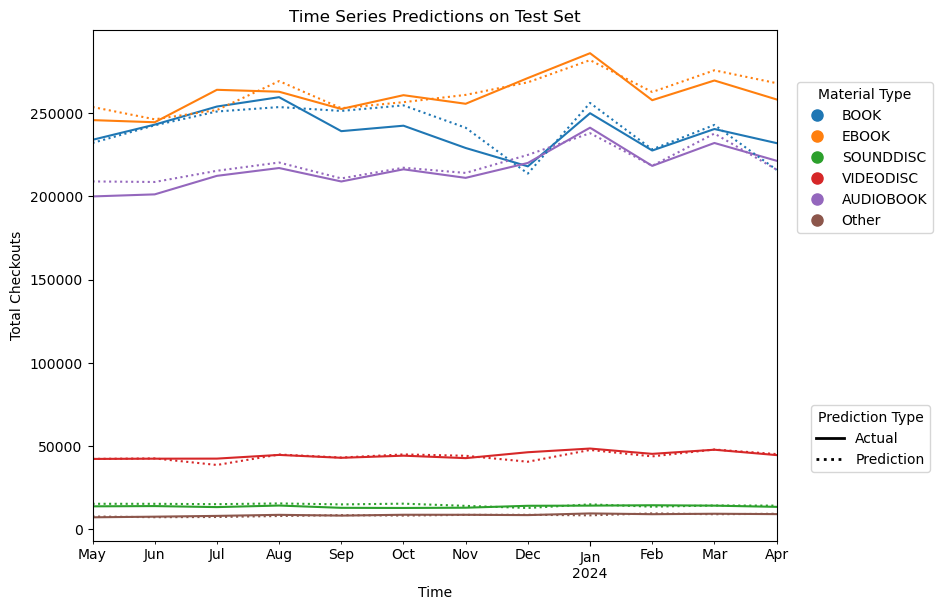

In [47]:
from matplotlib.lines import Line2D

df_end = df.iloc[217:]
#df_test_preds_end= df_test_preds.iloc[217:]


# Define corresponding colors for materials
colors = dict(zip(materials, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']))

# Define linestyles for different prediction types
linestyles = {'Actual': '-', 'Prediction': ':'}

# Plot predictions with whole time series
fig, ax = plt.subplots(figsize=(12, 6))
df_end.plot(x='Year-Month', y=materials, color=colors, ax=ax, xlabel = 'Time', ylabel='Total Checkouts')
df_test_preds.plot(x='Year-Month', y=materials, ls=linestyles['Prediction'], color=colors, ax=ax, xlabel = 'Time', ylabel='Total Checkouts')


# Create custom legends
color_handles = [Line2D([0], [0], color=color, marker='o', markersize=8, linestyle='None') for color in colors.values()]
linestyle_handles = [Line2D([0], [0], color='black', linestyle=style, lw=2) for style in linestyles.values()]

# Add legends outside the plot
color_legend = ax.legend(handles=color_handles, labels=materials, title='Material Type', loc='center left', bbox_to_anchor=(1.02, 0.75))
ax.add_artist(color_legend)  # Add material type legend first
linestyle_legend = ax.legend(handles=linestyle_handles, labels=linestyles.keys(), title='Prediction Type', loc='center left', bbox_to_anchor=(1.04, 0.2))

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Reserve space for the legends on the right
plt.title('Time Series Predictions on Test Set')
plt.show()
